In [1]:
!pip install ktext
!apt install python-pydot python-pydot-ng graphviz
# Unfortunately the installed packages tie to Python 2 instead of Python 3
!echo "Check with Python 2"
!python2 -c "import pydot"
!echo "Check with Python 3"
!python -c "import pydot"
!pip -V
!dot -V
!pip install pydot pydot-ng
!echo "Check again with Python 3"
!python -c "import pydot"

    100% |################################| 163kB 8.6MB/s ta 0:00:01
    100% |################################| 317kB 10.6MB/s ta 0:00:01
    100% |################################| 655kB 13.1MB/s ta 0:00:01
    100% |################################| 11.6MB 4.1MB/s eta 0:00:011
    100% |################################| 51kB 35.2MB/s ta 0:00:01
    100% |################################| 143kB 56.0MB/s ta 0:00:01
    100% |################################| 61kB 40.6MB/s ta 0:00:01
    100% |################################| 153kB 42.6MB/s ta 0:00:01
    100% |################################| 112kB 38.7MB/s ta 0:00:01
    100% |################################| 1.4MB 24.3MB/s ta 0:00:01
    100% |################################| 92kB 39.7MB/s ta 0:00:01
    100% |################################| 51kB 25.7MB/s ta 0:00:01
    100% |################################| 235kB 37.5MB/s ta 0:00:01
    100% |################################| 3.0MB 15.1MB/s ta 0:00:01
    100% |#############

    100% |################################| 122kB 44.0MB/s ta 0:00:01
    100% |################################| 1.2MB 21.7MB/s ta 0:00:01
    100% |################################| 194kB 49.0MB/s ta 0:00:01
    100% |################################| 604kB 31.2MB/s ta 0:00:01
    100% |################################| 51kB 31.1MB/s ta 0:00:01
  Running setup.py bdist_wheel for ktext ... done
  Stored in directory: /root/.cache/pip/wheels/d8/6e/20/7af144cfd34839158e8e7b50b62133e32bf44822976f27ae75
  Running setup.py bdist_wheel for pathos ... done
  Stored in directory: /root/.cache/pip/wheels/12/6b/3f/c9d2272bcd06caaf166988b27f72b7b08ab34ef211c8cbc4db
  Running setup.py bdist_wheel for ppft ... done
  Stored in directory: /root/.cache/pip/wheels/6f/25/0d/a2099d51db6f2a7c6019599bd3b62795da3bf76a6a4eb0e615
  Running setup.py bdist_wheel for dill ... done
  Stored in directory: /root/.cache/pip/wheels/e2/5d/17/f87cb7751896ac629b435a8696f83ee75b11029f5d6f6bda72
  Running setup.py bdist

  Running setup.py bdist_wheel for pydot-ng ... done
  Stored in directory: /root/.cache/pip/wheels/ef/d1/b6/e2b937c79d99d49b7db9233832a425c7e6b787486f5831b302
Successfully built pydot pydot-ng
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Check again with Python 3


In [ ]:
# Restart runtime to allow Jupyter to know the changes above
import os
os._exit(0)

In [1]:
import os, string, re

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, Bidirectional, BatchNormalization
from keras import optimizers, regularizers
from keras.utils import plot_model

from ktext.preprocess import processor
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [125]:
batch_size = 1200 # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 200  # Latent dimensionality of the encoding space.
num_samples = 50000  # Number of samples to train on.

In [3]:
!ls
#!rm -rf cnn*

datasets  storage  text2summary_colab.ipynb


In [4]:
!wget https://f001.backblazeb2.com/file/blazer/cnn.tgz

--2018-08-31 12:30:05--  https://f001.backblazeb2.com/file/blazer/cnn.tgz
Resolving f001.backblazeb2.com (f001.backblazeb2.com)... 162.244.62.199
Connecting to f001.backblazeb2.com (f001.backblazeb2.com)|162.244.62.199|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 217447312 (207M) [application/gzip]
Saving to: 'cnn.tgz'

cnn.tgz             100%[===================>] 207.37M  8.95MB/s    in 23s     

2018-08-31 12:30:29 (9.12 MB/s) - 'cnn.tgz' saved [217447312/217447312]



In [5]:
!tar -xf cnn.tgz

In [6]:
dataset_path = "./cnn/questions"

In [8]:
# Count how many files in training folder
!ls -l ./cnn/questions/training/ | grep -v ^l | wc -l

380299


In [9]:
def get_huge_dataset_list(path, limit=0):
    """
    Generator to help go through huge number of files under a path.
    By default, it generates all filenames.
    Set limit with any value > 0 to generate a limited number of filenames.  
    """
    count = 0
    for file in os.listdir(path): 
        yield file
        count = count + 1
        if count == limit and limit > 0:
            break

In [145]:
training_data_path = "{}/training".format(dataset_path)

# Vectorize the data.
input_texts = []
target_texts = []
input_words = set()
target_words = set()

for filename in get_huge_dataset_list(path=training_data_path, limit=num_samples):
    file = open("{}/{}".format(training_data_path, filename), "r", encoding="utf8")
    lines = file.readlines()
    
    input_alltext = lines[2].split('.')
    input_text = ''.join(input_alltext[1:10]) # 2nd - 10th lines
    input_text = input_text.replace('@entity', '')
    input_text = input_text.replace('\'s', '')
    input_text = input_text.replace('\'m', '')
    input_text = input_text.replace('\'d', '')
    input_text = re.sub(re.compile('[{}]'.format(string.punctuation)), '', input_text)
    input_text = re.sub(re.compile('[{}]'.format(string.digits)), '', input_text)
    input_text = re.sub(re.compile('\s+'), ' ', input_text)
    # input_text = re.sub(re.compile("\s+'"), "'", input_text)
    
    
    target_text = lines[4].strip() # Remove \n
    target_text = target_text.replace('@entity', '')
    target_text = target_text.replace('\'s', '')
    target_text = target_text.replace('\'m', '')
    target_text = target_text.replace('\'d', '')
    target_text = target_text.replace('@placeholder', '')
    target_text = re.sub(re.compile('[{}]'.format(string.punctuation)), '', target_text)
    target_text = re.sub(re.compile('[{}]'.format(string.digits)), '', target_text)
    target_text = re.sub(re.compile('\s+'), ' ', target_text)
    # target_text = re.sub(re.compile("\s+'"), "'", target_text)
    # print(input_text, '-->', target_text)
    
    input_texts.append(input_text)
    target_texts.append(target_text)
    for word in input_text.split():
        if word not in input_words:
            input_words.add(word)
    for word in target_text.split():
        if word not in target_words:
            target_words.add(word)

input_words = sorted(list(input_words))
target_words = sorted(list(target_words))

num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 50000
Number of unique input tokens: 47357
Number of unique output tokens: 18820
Max sequence length for inputs: 3264
Max sequence length for outputs: 207


In [153]:
# See https://github.com/hamelsmu/ktext/blob/master/ktext/preprocess.py
ratio = 0.25
body_keep_n = round(ratio * num_encoder_tokens)
body_padding_maxlen = round(ratio/4 * max_encoder_seq_length)
summary_keep_n = round(ratio * num_decoder_tokens)
summary_padding_maxlen = round(ratio/2 * max_decoder_seq_length)

print('Max vocab size (Unique number of words allowed) for input', body_keep_n)
print('Max sequence length for input', body_padding_maxlen)
print('Max vocab size (Unique number of words allowed) for output', summary_keep_n)
print('Max sequence length for output', summary_padding_maxlen)

Max vocab size (Unique number of words allowed) for input 11839
Max sequence length for input 204
Max vocab size (Unique number of words allowed) for output 4705
Max sequence length for output 26


In [154]:
body_pp = processor(keep_n=body_keep_n, padding_maxlen=body_padding_maxlen)
train_body_vecs = body_pp.fit_transform(input_texts)

In [155]:
print('original string:\n', input_texts[4])
print('after pre-processing:\n', train_body_vecs[4])
print('vector length:', len(train_body_vecs[4]))

original string:
  in scenes calmly mirroring the events of november crowds thronged through the center of the once divided city joining chancellor in a symbolic reenactment of the first crossing of the breached it was worth fighting for said after crossing the bridge on the checkpoint where people first poured across the frontier the first former to lead the reunified country was accompanied by leader and expresident as she kicked off events to celebrate the demise of the iconic structure and remember the darker sides of the communist regimes behind it it is not only a day of celebration for it is a day of celebration for the whole of said was joined by and president in a series of events including solemn tributes and boisterous music concerts at the climax a line of giant dominoes was knocked over along a kilometer strip where the once stood representing the domino effect the structure collapse had in ending communism across memorials were to be held for the lives lost of those who t

In [156]:
summary_pp = processor(
    append_indicators=True,
    keep_n=summary_keep_n,
    padding_maxlen=summary_padding_maxlen,
    padding ='post')

# process the summary data
train_summary_vecs = summary_pp.fit_transform(target_texts)

In [157]:
print('original string:\n', target_texts[4])
print('after pre-processing:\n', train_summary_vecs[4])
print('vector length:', len(train_summary_vecs[4]))

original string:
  leads ceremonies to mark years since collapse of 
after pre-processing:
 [   2  783    1    6 1767   68   78 2056    7    3    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
vector length: 26


In [158]:
import dill as dpickle
import numpy as np

# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('summary_pp.dpkl', 'wb') as f:
    dpickle.dump(summary_pp, f)

# Save the processed data
np.save('train_summary_vecs.npy', train_summary_vecs)
np.save('train_body_vecs.npy', train_body_vecs)

In [17]:
!wget https://raw.githubusercontent.com/hamelsmu/Seq2Seq_Tutorial/master/notebooks/seq2seq_utils.py

--2018-08-31 12:37:48--  https://raw.githubusercontent.com/hamelsmu/Seq2Seq_Tutorial/master/notebooks/seq2seq_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15129 (15K) [text/plain]
Saving to: 'seq2seq_utils.py'

seq2seq_utils.py    100%[===================>]  14.77K  --.-KB/s    in 0.007s  

2018-08-31 12:37:48 (2.17 MB/s) - 'seq2seq_utils.py' saved [15129/15129]



In [18]:
!pip install annoy
!pip install nltk
from seq2seq_utils import load_decoder_inputs, load_encoder_inputs, load_text_processor

    100% |################################| 634kB 8.5MB/s ta 0:00:011
  Running setup.py bdist_wheel for annoy ... done
  Stored in directory: /root/.cache/pip/wheels/96/af/26/f26df0a684b1e41ad8c56a13fc13e7a0a15a8a1a8b1cb0111a
Successfully built annoy
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |################################| 1.4MB 10.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /root/.cache/pip/wheels/d1/ab/40/3bceea46922767e42986aef7606a600538ca80de6062dc266c
Successfully built nltk
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [159]:
encoder_input_data, doc_length = load_encoder_inputs('train_body_vecs.npy')
decoder_input_data, decoder_target_data = load_decoder_inputs('train_summary_vecs.npy')

Shape of encoder input: (50000, 204)
Shape of decoder input: (50000, 25)
Shape of decoder target: (50000, 25)


In [160]:
num_encoder_tokens, body_pp = load_text_processor('body_pp.dpkl')
num_decoder_tokens, summary_pp = load_text_processor('summary_pp.dpkl')

Size of vocabulary for body_pp.dpkl: 11,841
Size of vocabulary for summary_pp.dpkl: 4,707


In [161]:
encoder_inputs = Input(shape=(doc_length,), name='Encoder-Input')

# Word embeding for encoder
x = Embedding(num_encoder_tokens, latent_dim, name='Body-Word-Embedding', mask_zero=False)(encoder_inputs)
x = BatchNormalization(name='Encoder-Batchnorm-1')(x)

# Intermediate GRU layer
x = GRU(
    latent_dim,
    name='Encoder-Intermediate-GRU',
    return_sequences=True,
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01))(x)

x = BatchNormalization(name='Encoder-Batchnorm-2')(x)

# We just need the hidden state of last time step
_, state_h = GRU(
    latent_dim,
    return_state=True,
    name='Encoder-Last-GRU',
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01))(x)

# Encapsulate the encoder as a separate entity so we can just 
#  encode without decoding if we want to.
encoder_model = Model(inputs=encoder_inputs, outputs=state_h, name='Encoder-Model')

seq2seq_encoder_out = encoder_model(encoder_inputs)

In [162]:
decoder_inputs = Input(shape=(None,), name='Decoder-Input')  # for teacher forcing

# Word Embedding For Decoder
dec_emb = Embedding(num_decoder_tokens, latent_dim, name='Decoder-Word-Embedding', mask_zero=False)(decoder_inputs)
dec_bn = BatchNormalization(name='Decoder-Batchnorm-1')(dec_emb)

# Set up the decoder, using `decoder_state_input` as initial state.
decoder_gru = GRU(
    latent_dim,
    return_state=True,
    return_sequences=True,
    name='Decoder-GRU',
    kernel_regularizer=regularizers.l2(0.01),
    recurrent_regularizer=regularizers.l2(0.01))

decoder_gru_output, _ = decoder_gru(dec_bn, initial_state=seq2seq_encoder_out)
x = BatchNormalization(name='Decoder-Batchnorm-2')(decoder_gru_output)

# Dense layer for prediction
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='Final-Output-Dense')
decoder_outputs = decoder_dense(x)

In [163]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers.Nadam(lr=0.001), loss='sparse_categorical_crossentropy')
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Decoder-Input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
Decoder-Word-Embedding (Embeddi (None, None, 200)    941400      Decoder-Input[0][0]              
__________________________________________________________________________________________________
Encoder-Input (InputLayer)      (None, 204)          0                                            
__________________________________________________________________________________________________
Decoder-Batchnorm-1 (BatchNorma (None, None, 200)    800         Decoder-Word-Embedding[0][0]     
__________________________________________________________________________________________________
Encoder-Mo

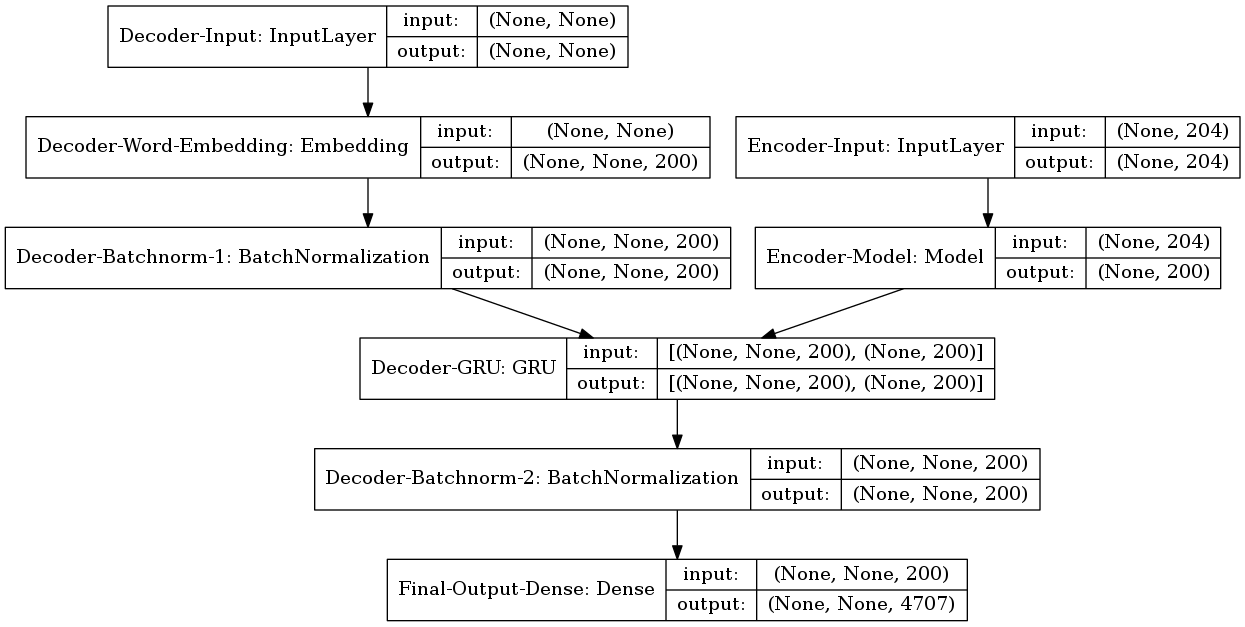

In [164]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [165]:
# history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
#           batch_size=batch_size,
#          epochs=epochs,
#          validation_split=0.2)

history = model.fit([encoder_input_data, decoder_input_data], np.expand_dims(decoder_target_data, -1),
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.05)
# Save model
model.save('dmqa_s2s.h5')

Train on 47500 samples, validate on 2500 samples
Epoch 1/50
47500/47500 [==============================] - 30s 631us/step - loss: 12.9008 - val_loss: 6.2138
Epoch 2/50
47500/47500 [==============================] - 24s 500us/step - loss: 4.2937 - val_loss: 3.5934
Epoch 3/50
47500/47500 [==============================] - 24s 505us/step - loss: 2.6085 - val_loss: 3.8721
Epoch 4/50
47500/47500 [==============================] - 25s 519us/step - loss: 2.1909 - val_loss: 3.6731
Epoch 5/50
47500/47500 [==============================] - 24s 500us/step - loss: 2.0494 - val_loss: 3.3555
Epoch 6/50
47500/47500 [==============================] - 24s 499us/step - loss: 1.9785 - val_loss: 3.8711
Epoch 7/50
47500/47500 [==============================] - 24s 497us/step - loss: 1.9258 - val_loss: 3.3539
Epoch 8/50
47500/47500 [==============================] - 24s 501us/step - loss: 1.8839 - val_loss: 3.0782
Epoch 9/50
47500/47500 [==============================] - 24s 501us/step - loss: 1.8483 - val_

/usr/local/lib/python3.6/dist-packages/keras/engine/topology.py:2379: UserWarning: Layer Decoder-GRU was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'Encoder-Model_8/Encoder-Last-GRU/while/Exit_2:0' shape=(?, 200) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


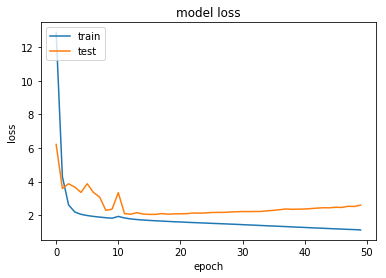

In [166]:
# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [167]:
from seq2seq_utils import Seq2Seq_Inference
seq2seq_inf = Seq2Seq_Inference(encoder_preprocessor=body_pp,
                                 decoder_preprocessor=summary_pp,
                                 seq2seq_model=model)

In [168]:
for txt in input_texts[:20]:
    print("Original txt:", txt)
    emb, summ = seq2seq_inf.generate_issue_title(txt)
    print("Summary:", summ)
    print("----")
 

Original txt:  who lost his ability to speak after a bout with cancer was given the award for blogging and using social media tools to get his writing voice back and the internet have allowed to continue the work we came to know and love him for said who presented award i ca nt remember the last time i went to see a movie without seeing what thought of it first founder year old was given the award website which lets people chat face to face with strangers has been praised by some for breaking down social and national cliques online others have called it a den for pornography executive director of the said story shows the equalizing power of the i think it incredible that this far into the something can be created by a year old kid in and literally all of the major global media is talking about it three days later he said it really shows the kind of impact you can have on the internet 
Summary: never making debut for album
----
Original txt:  it brought glory to the embattled space prog

Summary: deaths are suspected or confirmed in
----
Original txt:  missed out on a second successive tournament after a aggregate defeat to which has a population of trailing following last week first leg loss in the fell further behind when striker gave a surprise lead in the capital of equalized for before half time but despite boasting the attacking talent of former and striker the home team were unable to find the back of the net a late goal from year old debutant who is a graduate of the finally put ahead in the match but it was nt enough to prevent reaching their also through to january team tournament in is who beat to advance on away goals to reach the tournament for the first time in year lost the first leg but progressed courtesy of goals from and in the tournament won by in is ordinarily held every two years but it is being staged in to avoid the competition clashing with future and the overturned a first leg deficit to beat on away goals former striker scored two headed goal

Summary: played role in practice for long time
----
Original txt:  announced his undersea exploration venture earlier this month and in a recent interview with he discussed the plans for his upcoming voyage to the bottom of the seabed there have been about people who have been into space but pretty well nobody has been down and explored the big trenches in the oceans said the founder of the business empire i am planning to go down in the trench it goes down further than is high about feet the airplane shaped sub is built from carbon fiber and titanium with a bubble like quartz viewing dome made to withstand over million kilograms of pressure according to the flying sub has overcome two big obstacles facing deep sea explorers extreme cold and pressures of over atmospheres about the same as elephants standing on a 
Summary: two diving gold medals at the table
----


### Test

In [175]:
# Test with recent passages from CNN
# https://edition.cnn.com/2018/08/31/us/california-carr-fire-contained/index.html
txt = """
Northern California's deadly and monstrous Carr Fire, ignited last month after the rim of a trailer's flat tire scraped the asphalt, has been fully contained, state fire official said late Thursday.
"""
emb, summ = seq2seq_inf.generate_issue_title(txt)
summ

'another prominent lawmakers are named'

In [176]:
txt = """
The sparks from the seemingly ordinary July 23 incident on a road near Redding set off one of the most destructive wildfires in state history and killed eight people, including three fire personnel. It also destroyed more than 1,000 homes and consumed 229,651 acres, according to California fire officials said.
"""
emb, summ = seq2seq_inf.generate_issue_title(txt)
summ

'and are held in for months after elections'